# Filename: ResNet18_SGD
## Experiments for ResNet18 model on CIFAR10 trained with SGD

### Load source model attack file from checkpoint_submission folder attached 
#### No_noise_ckpt5_lrstep.h5 - Target Model 
#### No_noise_ckpt4_lrstep.h5 - Source Model for Blackbox attacks
### Loss Surface, Adversarial Dimensionality ,  PC Variance , PC Visualization of Adversarial/Clean Data, Cosine Distance  between adversarial/clean data shown in this file (below)
#### Adv_space_SGD_epsilon_8.h5 - Stores adversarial Dimension of SGD model to plot the comaprative plot in Adversarial_Dimensionality(NoLvsSGD)
#### PC_dim_SGD.h5 - Stores cosine distance of adv./clean response of SGD model to plot the comaprative plot in PC_CosineDistance(NoLvsSGD)

In [1]:
from __future__ import print_function
import torch
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torchvision
device_id =3
torch.cuda.set_device(device_id)

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

model=ResNet18()

### Note, model file 'No_noise_ckpt5_lrstep.h5' that is the target model could not be uploaded into the checkpoint_submission folder due to size limit. Please train a model using the cell numbers 13-15, 26 below which will save the file and then all remaining experiments can be run

In [3]:
def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))
#model_path = './checkpoint_submission/No_noise_ckpt5_lrstep.h5' 
#model.load_state_dict(torch.load(model_path))

In [4]:
torch.manual_seed(6289)

In [5]:
# Training settings
batch_size = 64

In [6]:
# CIFAR10 Dataset

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
])

train_dataset = datasets.CIFAR10(root='./../My_Tutorial/data/cifar_data',
                               train=True,
                               transform=transform_test,
                               download=True)

test_dataset = datasets.CIFAR10(root='./../My_Tutorial/data/cifar_data',
                              train=False,
                              transform=transform_test, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
# functions to show an image
def My_imshow_image(img):
    #print(torch.min(img))
    #print(torch.max(img))
    npimg = img.numpy().transpose((1,2,0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std*npimg + mean
    #print(np.min(inp))
    #print(np.max(inp))
    plt.imshow(inp)
    #plt.imshow(transforms.ToPILImage(npimg))



torch.Size([64, 3, 32, 32])
 ship  bird  deer  deer


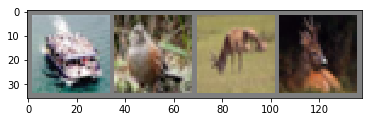

In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
# show images
plt.figure()
My_imshow_image(torchvision.utils.make_grid(images[0:4,:,:,:]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
def My_imshow_noise(img):
    npimg = img.numpy().transpose((1,2,0))
    min_val = np.min(npimg, keepdims =True)
    print('min',min_val)
    max_val = np.max(npimg, keepdims =True)
    print('max',max_val)
    inp = (npimg-min_val)/(max_val-min_val)
   # inp = npimg
    plt.imshow(inp)

min [[[-1.]]]
max [[[1.]]]
 ship


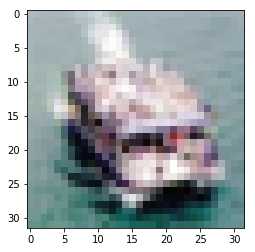

In [11]:
plt.figure()
My_imshow_noise(torchvision.utils.make_grid(images[0,:,:,:]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [12]:
acc = Variable(torch.Tensor([0]))

In [13]:
#torch.nn.DataParallel(model, device_ids= [0, 3]).cuda()
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay = 5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [14]:
def train(epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # zero the parameter gradients
        optimizer.zero_grad()
        bsize = inputs.size(0)
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [15]:
def test():
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    for data in test_loader:
        images, labels = data
        inputs, target = Variable(images.cuda()),Variable(labels.cuda())
        outputs = model(inputs)
        total += labels.size(0)
        test_loss += criterion(outputs, target).data[0]
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc.data = torch.Tensor([100. * correct / len(test_loader.dataset)])

### Running below cell will train the target model and save it into filename No_noise_ckpt5_lrstep.h5

In [26]:
for epoch in range(1, 121):
    scheduler.step()
    train(epoch)
    test()
    if epoch%20==0:
        save_model(model, model_path)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.323089
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.922541
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.594652
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.601490
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.719792
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.322308
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.314020
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.225579

Test set: Average loss: 0.0193, Accuracy: 5502/10000 (55%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.983807
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.369286
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.005738
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.223064
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.937378
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.993824
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.112589
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.061282

Test set: Average loss: 0.0173, Accuracy: 6282/10000 (63%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.987190
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.900


Test set: Average loss: 0.0111, Accuracy: 7730/10000 (77%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.295916
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.227461
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.473663
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.291031
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.678970
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.315156
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.318029
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.472006

Test set: Average loss: 0.0120, Accuracy: 7536/10000 (75%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.387388
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.335754
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.546805
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.409344
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.397199
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.410907
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.396581
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.413359

Test set: Average loss: 0.0138, Accuracy: 7275/10000 (73%)

Train Epoch: 

Train Epoch: 36 [38400/50000 (77%)]	Loss: 0.008257
Train Epoch: 36 [44800/50000 (90%)]	Loss: 0.001607

Test set: Average loss: 0.0064, Accuracy: 8861/10000 (89%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.005095
Train Epoch: 37 [6400/50000 (13%)]	Loss: 0.004720
Train Epoch: 37 [12800/50000 (26%)]	Loss: 0.004042
Train Epoch: 37 [19200/50000 (38%)]	Loss: 0.003732
Train Epoch: 37 [25600/50000 (51%)]	Loss: 0.001952
Train Epoch: 37 [32000/50000 (64%)]	Loss: 0.002391
Train Epoch: 37 [38400/50000 (77%)]	Loss: 0.001873
Train Epoch: 37 [44800/50000 (90%)]	Loss: 0.006190

Test set: Average loss: 0.0065, Accuracy: 8854/10000 (89%)

Train Epoch: 38 [0/50000 (0%)]	Loss: 0.002010
Train Epoch: 38 [6400/50000 (13%)]	Loss: 0.003914
Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.002671
Train Epoch: 38 [19200/50000 (38%)]	Loss: 0.001636
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.008889
Train Epoch: 38 [32000/50000 (64%)]	Loss: 0.001827
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.007996
Train Epoch: 38 [44800/

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.001477
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.003202
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.001584
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.001666

Test set: Average loss: 0.0061, Accuracy: 8878/10000 (89%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.002820
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.002183
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.001568
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.002080
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.002061
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.001792
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.002564
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.001588

Test set: Average loss: 0.0061, Accuracy: 8876/10000 (89%)

Train Epoch: 56 [0/50000 (0%)]	Loss: 0.005979
Train Epoch: 56 [6400/50000 (13%)]	Loss: 0.001505
Train Epoch: 56 [12800/50000 (26%)]	Loss: 0.001418
Train Epoch: 56 [19200/50000 (38%)]	Loss: 0.001811
Train Epoch: 56 [25600/50000 (51%)]	Loss: 0.001384
Train Epoch: 56 [32000/

Train Epoch: 72 [12800/50000 (26%)]	Loss: 0.001809
Train Epoch: 72 [19200/50000 (38%)]	Loss: 0.002116
Train Epoch: 72 [25600/50000 (51%)]	Loss: 0.002380
Train Epoch: 72 [32000/50000 (64%)]	Loss: 0.001685
Train Epoch: 72 [38400/50000 (77%)]	Loss: 0.001791
Train Epoch: 72 [44800/50000 (90%)]	Loss: 0.001350

Test set: Average loss: 0.0061, Accuracy: 8873/10000 (89%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.001804
Train Epoch: 73 [6400/50000 (13%)]	Loss: 0.001728
Train Epoch: 73 [12800/50000 (26%)]	Loss: 0.001934
Train Epoch: 73 [19200/50000 (38%)]	Loss: 0.001522
Train Epoch: 73 [25600/50000 (51%)]	Loss: 0.001636
Train Epoch: 73 [32000/50000 (64%)]	Loss: 0.002165
Train Epoch: 73 [38400/50000 (77%)]	Loss: 0.001526
Train Epoch: 73 [44800/50000 (90%)]	Loss: 0.002390

Test set: Average loss: 0.0061, Accuracy: 8878/10000 (89%)

Train Epoch: 74 [0/50000 (0%)]	Loss: 0.001415
Train Epoch: 74 [6400/50000 (13%)]	Loss: 0.001363
Train Epoch: 74 [12800/50000 (26%)]	Loss: 0.004742
Train Epoch: 74 [19200/

Train Epoch: 90 [6400/50000 (13%)]	Loss: 0.002453
Train Epoch: 90 [12800/50000 (26%)]	Loss: 0.002150
Train Epoch: 90 [19200/50000 (38%)]	Loss: 0.001359
Train Epoch: 90 [25600/50000 (51%)]	Loss: 0.001289
Train Epoch: 90 [32000/50000 (64%)]	Loss: 0.001818
Train Epoch: 90 [38400/50000 (77%)]	Loss: 0.002132
Train Epoch: 90 [44800/50000 (90%)]	Loss: 0.001731

Test set: Average loss: 0.0061, Accuracy: 8880/10000 (89%)

Train Epoch: 91 [0/50000 (0%)]	Loss: 0.001889
Train Epoch: 91 [6400/50000 (13%)]	Loss: 0.001837
Train Epoch: 91 [12800/50000 (26%)]	Loss: 0.001462
Train Epoch: 91 [19200/50000 (38%)]	Loss: 0.001830
Train Epoch: 91 [25600/50000 (51%)]	Loss: 0.002170
Train Epoch: 91 [32000/50000 (64%)]	Loss: 0.001893
Train Epoch: 91 [38400/50000 (77%)]	Loss: 0.001458
Train Epoch: 91 [44800/50000 (90%)]	Loss: 0.001871

Test set: Average loss: 0.0061, Accuracy: 8870/10000 (89%)

Train Epoch: 92 [0/50000 (0%)]	Loss: 0.001621
Train Epoch: 92 [6400/50000 (13%)]	Loss: 0.001488
Train Epoch: 92 [12800/5

Train Epoch: 107 [44800/50000 (90%)]	Loss: 0.001838

Test set: Average loss: 0.0061, Accuracy: 8873/10000 (89%)

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.001466
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.001645
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.001927
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.001471
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.001229
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.001896
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.001781
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.001853

Test set: Average loss: 0.0061, Accuracy: 8877/10000 (89%)

Train Epoch: 109 [0/50000 (0%)]	Loss: 0.001727
Train Epoch: 109 [6400/50000 (13%)]	Loss: 0.001723
Train Epoch: 109 [12800/50000 (26%)]	Loss: 0.001954
Train Epoch: 109 [19200/50000 (38%)]	Loss: 0.001857
Train Epoch: 109 [25600/50000 (51%)]	Loss: 0.001485
Train Epoch: 109 [32000/50000 (64%)]	Loss: 0.002076
Train Epoch: 109 [38400/50000 (77%)]	Loss: 0.001234
Train Epoch: 109 [44800/50000 (90%)]	Loss: 0.001305

Test 

In [16]:
test()

/data/pandap/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()



Test set: Average loss: 0.0061, Accuracy: 8885/10000 (88%)



# ADVERSERIAL ATTACKS

### Load source model 'No_noise_ckpt4_lrstep.h5' stored in checkpoint_submission folder in model_new.
### This model_new serves as source model for Blackbox attack 

In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

model_new=ResNet18()

In [18]:
model_path = './checkpoint_submission/No_noise_ckpt4_lrstep.h5'
load_model(model_new, model_path)
model_new = model_new.cuda()

In [19]:
# Images from test_loader
images, labels = next(dataiter)
inp_var = Variable(images.cuda(), requires_grad = True)
true_label= Variable(labels.cuda(), requires_grad = False)

In [20]:
inp_var_perp = Variable(images.cuda(), requires_grad = True)

# Loss Surface Calculation

In [21]:
#only for floating point range values of eps
def g_loss(EPS1, EPS2):
    g_loss_val = np.zeros([8,8])
    output_perp = model_new(inp_var_perp) #blackbox attack
    output_par = model(inp_var, mean_noise.cuda()) #whitebox attack
    loss_ad_perp = criterion(output_perp, true_label) 
    loss_ad_perp.backward() #obtain gradient on output_perp to calculate blackbox attack gradients
    loss_ad_par = criterion(output_par, true_label)
    loss_ad_par.backward() #obtain gradient on output_par to calculate whitebox attack gradients
 # Add perturbation for untargeted attack where AIM is to misclassify adversary 
    inp_var_grad_par   = torch.sign(inp_var.grad.data)
    inp_var_grad_perp   = torch.sign(inp_var_perp.grad.data)
    for eps1 in np.arange(0,4,0.5):
        for eps2 in np.arange(0,4,0.5):
            total_adv_perp = eps1/10 * inp_var_grad_par
            total_adv_par = eps2/10 * inp_var_grad_perp
            inp_adversarial = inp_var.data + total_adv_perp.cuda() + total_adv_par.cuda()
            image_adv = inp_adversarial.cpu()
            out_adv = model(Variable(inp_adversarial))
            loss_adv_target = criterion(out_adv, true_label)
            i=int(eps1*2)
            j=int(eps2*2)
            g_loss_val[i][j] = loss_adv_target.data.cpu().numpy()
    return g_loss_val

In [22]:
eps_1 = np.arange(0,4,0.5)/10
eps_2 = np.arange(0,4,0.5)/10
EPS1, EPS2 = np.meshgrid(eps_1, eps_2)
loss_val =g_loss(EPS1, EPS2)

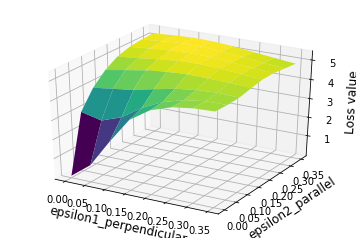

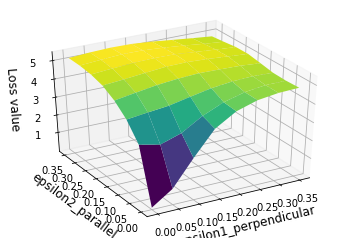

In [23]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(EPS1, EPS2, loss_val,1000)
ax.plot_surface(EPS1, EPS2, loss_val, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('epsilon1_perpendicular', fontsize='large') # Blackbox attack direction
ax.set_ylabel('epsilon2_parallel',fontsize='large') # Whitebox attack direction
ax.set_zlabel('Loss value',fontsize='large');
plt.show()
fig
ax.view_init(35, -120)
fig

# Adversarial Subspace Calculation

In [24]:
false_list_256=[]
dataiter = iter(test_loader)

## Run the three cells (Cell A, Cell B, Cell C) below 6 times to calculate average of 6*64 images for adversarial dimensionality

min [[[-0.9137255]]]
max [[[1.0313725]]]


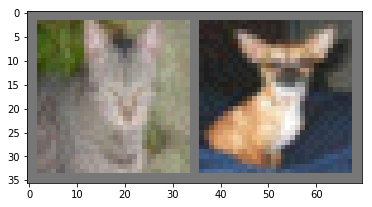

In [44]:
 # Cell A

images, labels = dataiter.next()
inp_var = Variable(images.cuda(), requires_grad = True)
true_label= Variable(labels.cuda(), requires_grad = False)
output = model_new(inp_var)
loss_ad = criterion(output, true_label)
loss_ad.backward() #obtain gradient on inp_var to create black box adversarial perturbations
epsilon = 8/255 
inp_var_grad   = torch.sign(inp_var.grad.data)
inp_adversarial = inp_var.data + epsilon * inp_var_grad
image_adv = inp_adversarial.cpu()
plt.figure()
My_imshow_noise(torchvision.utils.make_grid(image_adv[0:2,:,:,:]))

In [45]:
# Cell B

from scipy.linalg import hadamard
num_dir =np.array([1,4,8,16,32,64,128])
false_list=[]
for i in range(len(num_dir)):
    num_chunks = int(3072/num_dir[i])

    r_dir = hadamard(num_dir[i])
#print(r_dir.shape)
    r_inp = np.zeros([num_dir[i],3,32,32])
    for j in range(0,num_dir[i]):
        r_inp[j,:,:,:] = np.tile(r_dir[j,:],num_chunks).reshape(3,32,32)
    r_final=np.zeros([batch_size,num_dir[i],3,32,32])
    for k in range(batch_size):
        r_final[k,:,:,:,:] = r_inp * inp_var_grad[k,:,:,:] * epsilon   
    false_match1 = np.zeros(num_dir[i])
    for l in range(num_dir[i]):
        inp_adv = inp_var.data.cpu().numpy() + r_final[:,l,:,:,:]
        inp_adv = torch.Tensor(inp_adv)
        y_pred_adversarial = np.argmax(model(Variable(inp_adv).cuda()).data.cpu().numpy(), axis =1)
        count = 0
        for m in range(batch_size):
            if y_pred_adversarial[m]!=labels[m]:
                count = count +1
    #print('False match:',count)
        false_match1[l] = count
    false_list.append(np.mean(false_match1)/64)
#print(r_inp.shape)

In [46]:
#Cell C

false_list_256.append(false_list)

In [47]:
false_list_256

[[0.421875,
  0.28125,
  0.251953125,
  0.2392578125,
  0.2333984375,
  0.220703125,
  0.2166748046875],
 [0.296875,
  0.1640625,
  0.146484375,
  0.1357421875,
  0.130859375,
  0.137939453125,
  0.136474609375],
 [0.421875,
  0.2109375,
  0.177734375,
  0.1650390625,
  0.15869140625,
  0.14794921875,
  0.1495361328125],
 [0.40625,
  0.23046875,
  0.208984375,
  0.193359375,
  0.19091796875,
  0.17529296875,
  0.1751708984375],
 [0.46875,
  0.21875,
  0.19140625,
  0.1689453125,
  0.15869140625,
  0.150634765625,
  0.1485595703125],
 [0.4375,
  0.2421875,
  0.197265625,
  0.169921875,
  0.16455078125,
  0.155517578125,
  0.155517578125]]

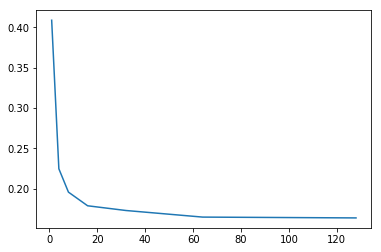

In [48]:
a_sum = np.sum(false_list_256, axis=0)/6
x1=np.array([1,4,8,16,32,64,128])
y1=np.array(a_sum)
plt.plot(x1,y1)

In [49]:
state={'x':x1, 'y':y1}
torch.save(state,'./checkpoint_submission/Adv_space_SGD_epsilon_8.h5')

# Attack Methods and Adversarial Accuracy Calculation

### FGSM attack -Whitebox

In [25]:
# WITH CUDA Add SINGLE_STEP perturbation cross entropy loss
correct_count = 0
correct_count_orig = 0
non_targeted = True
epsilon = 8/255
for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels_tru = data
        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        
        output = model(inp_var)
        y_pred_orig=  output.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
        if non_targeted:
            loss_ad = criterion(output, true_label)
                
        loss_ad.backward() 
         # Add perturbation
        
        inp_var_grad   = torch.sign(inp_var.grad.data)
        total_adv = epsilon*inp_var_grad # Linf attack 
        if non_targeted:
            inp_adversarial = inp_var.data + total_adv
        else:
            inp_adversarial = inp_var.data - total_adv
        y_prob = model(Variable(inp_adversarial).cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()


print('Clean Accuracy * 100:',correct_count_orig)
print('adversarial Accuracy * 100:',correct_count)

Clean Accuracy * 100: tensor(8885)
adversarial Accuracy * 100: tensor(2214)


Note  all Blackbox attacks are created from source model (trained with SGD)- model_new loaded from No_noise_ckpt4_lrstep.h5 above

### FGSM attack- Blackbox 

In [26]:
# WITH CUDA Add SINGLE_STEP perturbation cross entropy loss
correct_count = 0
correct_count_orig = 0
non_targeted = True
epsilon = 8/255

for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels_tru = data
        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        
        output = model_new(inp_var)
        with torch.no_grad():
            output_target = model(inp_var)
        y_pred_orig=  output_target.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
        if non_targeted:
            loss_ad = criterion(output, true_label)

                
        loss_ad.backward() 
         # Add perturbation
        
        inp_var_grad   = torch.sign(inp_var.grad.data)
        total_adv = epsilon*inp_var_grad # Linf attack 
        if non_targeted:
            inp_adversarial = inp_var.data + total_adv

        y_prob = model(Variable(inp_adversarial).cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()

print('Clean Accuracy *100:',correct_count_orig)
print('Adversarial Accuracy * 100:',correct_count)

Clean Accuracy *100: tensor(8885)
Adversarial Accuracy * 100: tensor(6310)


### PGD attack- Whitebox

In [27]:
# Add ITERATIVE PGD perturbation
correct_count = 0
correct_count_orig = 0
epsilon = 8/255
num_steps=7
alpha = 2/255
num_classes = 10
for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels_tru = data
        

        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        with torch.no_grad():
            output_target = model(inp_var)
        y_pred_orig=  output_target.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
         # Add ITERATIVE perturbation
        step =0
        inp_adv = Variable((inp_var.data.cpu() + (2* epsilon*torch.rand(inp_var.data.size())
                                           - epsilon)).cuda(), requires_grad = True) 
        while step < num_steps:
            output = model(inp_adv)
            loss_ad = criterion(output, true_label)
            loss_ad.backward() #obtain gradient on inp_var
            eta = alpha * torch.sign(inp_adv.grad.data)
            eta = torch.clamp(eta, -epsilon, epsilon)
            inp_adv.data += eta
            step +=1
            
        y_prob = model(inp_adv.cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()
        #stop+=1
        

print('Clean accuracy:',correct_count_orig) #Note, divide by 100 for % accuracy
print('Adversarial accuracy:',correct_count) #Note, divide by 100 for % accuracy

Clean accuracy: tensor(8885)
Adversarial accuracy: tensor(51)


### PGD attack - Blackbox 

In [28]:
# Add ITERATIVE PGD perturbation
correct_count = 0
correct_count_orig = 0
epsilon = 8/255
num_steps=7
alpha = 2/255
num_classes = 10
for batch_idx, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels_tru = data
        

        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        with torch.no_grad():
            output_target = model(inp_var)
        y_pred_orig=  output_target.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
         # Add ITERATIVE perturbation
        step =0
        inp_adv = Variable((inp_var.data.cpu() + (2* epsilon*torch.rand(inp_var.data.size())
                                           - epsilon)).cuda(), requires_grad = True) 
        while step < num_steps:
            output = model_new(inp_adv)
            loss_ad = criterion(output, true_label)
            loss_ad.backward() #obtain gradient on inp_var
            eta = alpha * torch.sign(inp_adv.grad.data)
            eta = torch.clamp(eta, -epsilon, epsilon)
            inp_adv.data += eta
            step +=1
            
        y_prob = model(inp_adv.cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()
        

print('Clean accuracy:',correct_count_orig) #Note, divide by 100 for % accuracy
print('Adversarial accuracy:',correct_count) #Note, divide by 100 for % accuracy

Clean accuracy: tensor(8885)
Adversarial accuracy: tensor(1594)


# PC Analysis

### Intermediate PCA for more data

In [57]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [29]:
#Gather the conv1 layer parameters from ResNet18 target model to conduct PCA on the Conv1 layer's activations 
res18_model = model
res18_model_conv1 = nn.Sequential(*list(res18_model.children())[0:2])
for param in res18_model_conv1.parameters():
    param.requires_grad=False
    
#res18_model_bl1 = nn.Sequential(*list(res18_model.children())[2:3])
#for param in res18_model_bl1.parameters():
#    param.requires_grad=False
    
#res18_model_bl2 = nn.Sequential(*list(res18_model.children())[3:4])
#for param in res18_model_bl2.parameters():
#    param.requires_grad=False
    
#res18_model_bl3 = nn.Sequential(*list(res18_model.children())[4:5])
#for param in res18_model_bl3.parameters():
#    param.requires_grad=False

#res18_model_bl4 = nn.Sequential(*list(res18_model.children())[5:6])
#for param in res18_model_bl4.parameters():
#    param.requires_grad=False
    
#res18_model_linear= nn.Sequential(*list(res18_model.children())[-1:])
#for param in res18_model_linear.parameters():
#    param.requires_grad=False

### N = 64*11 for doing PC experiments

In [30]:
x_vec=[]
x_vec_adv=[]
x_vec_inp=[]
x_vec_advinp=[]
x_vec_label=[]
dataiter = iter(test_loader)

In [31]:
for i in range(0,11):
    correct_count = 0
    correct_count_orig = 0
    non_targeted = True
    epsilon = 8/255
    stop =0
    while(stop==0):
        # get the inputs
        inputs, labels_tru = dataiter.next() 
        # wrap them in Variable
        inp_var, true_label = Variable(inputs.cuda(), requires_grad = True), Variable(labels_tru.cuda()
                                                                                      , requires_grad = False)
        
        output = model_new(inp_var)
        y_pred_orig=  output.data.max(1, keepdim=True)[1]
        correct_count_orig += y_pred_orig.eq(true_label.data.view_as(y_pred_orig)).cpu().sum()
        if non_targeted:
            loss_ad = criterion(output, true_label)
        else:
            true_label.data= output.data.max(1)[1]
            loss_ad = criterion(output, true_label)
                
        loss_ad.backward() 
         # Add perturbation
        
        inp_var_grad   = torch.sign(inp_var.grad.data)
        total_adv = epsilon*inp_var_grad # Linf attack 
        if non_targeted:
            inp_adversarial = inp_var.data + total_adv
        else:
            inp_adversarial = inp_var.data - total_adv
        #total_adv
        inp_adversarial = torch.clamp(inp_adversarial, -1.5, 1.5)
        y_prob = model(Variable(inp_adversarial).cuda())
        y_pred = y_prob.data.max(1, keepdim=True)[1]
        correct_count += y_pred.eq(true_label.data.view_as(y_pred)).cpu().sum()
        stop+=1
    
    inputs = inputs
    inp_var, label_var = Variable(inputs.cuda()), Variable(labels.cuda())
    outputs_conv1=res18_model_conv1(inp_var)
    x_c_pc = outputs_conv1.data.cpu()
    x_c_pc = x_c_pc[:,:,:,:].numpy().reshape((-1,64*32*32))
    x_vec.append(x_c_pc)
    x_c_inp=inputs.numpy().reshape(-1,32*32*3)
    x_vec_inp.append(x_c_inp)
    x_c_inpadv=inp_adversarial.cpu().numpy().reshape(-1,32*32*3)
    x_vec_advinp.append(x_c_inpadv)
    x_vec_label.append(labels_tru.numpy().reshape(-1))
    outputs_conv1_adv=res18_model_conv1(Variable(inp_adversarial.cpu()).cuda())
    x_c_pc_adv = outputs_conv1_adv.data.cpu()
    x_c_pc_adv = x_c_pc_adv[:,:,:,:].numpy().reshape((-1,64*32*32))
    x_vec_adv.append(x_c_pc_adv)

### PC variance calculation for Conv1 layer of ResNet18 in response to clean inputs

In [32]:
from sklearn.decomposition import PCA
ar= np.array(x_vec)
ar = ar.reshape(11*64, 64*32*32)
mean_pc= np.mean(ar, axis=0)
pca1 = PCA()
pca1.fit(ar-mean_pc)
pc_sc1 = pca1.explained_variance_ratio_
c_eig = sorted(pc_sc1, reverse=True)

Text(0,0.5,'% Cumulative Variance')

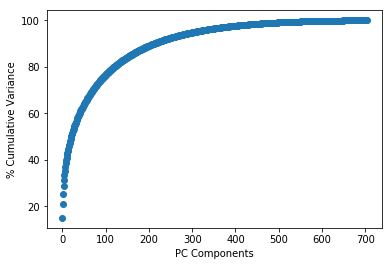

In [33]:
fig = plt.figure()
n_PC = len(c_eig)
ax = fig.add_subplot(111)
#ax1 = fig.add_subplot(211)
tot = sum(c_eig)
var_exp = [(i/tot)*100 for i in c_eig[0:n_PC]]
cum_var_exp = np.cumsum(var_exp)
trace2 = plt.scatter(
        x=[i for i in range(0,n_PC)], y=cum_var_exp)
ax.set_xlabel('PC Components')
ax.set_ylabel('% Cumulative Variance')

#### Variance for PC1 - PC100 for clean data response at Conv1 layer of ResNet18

In [34]:
val = sum(c_eig[0:100]/tot)
print(val) #Note, the value shown is (% Variance)/100

0.7640138621209189


### PC variance calculation for Conv1 layer of ResNet18 in response to adversarial inputs

In [35]:
from sklearn.decomposition import PCA
ar1= np.array(x_vec_adv)
ar1 = ar1.reshape(11*64, 64*32*32)
mean_pc_adv= np.mean(ar1, axis=0)
pca2 = PCA()
pca2.fit(ar1-mean_pc_adv)
pc_sc = pca2.explained_variance_ratio_
c_eig_adv = sorted(pc_sc, reverse=True)

Text(0,0.5,'% Cumulative Variance')

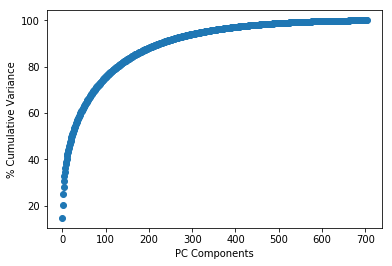

In [36]:
fig = plt.figure()
n_PC = len(c_eig_adv)
ax = fig.add_subplot(111)
#ax1 = fig.add_subplot(211)
tot = sum(c_eig_adv)
var_exp = [(i/tot)*100 for i in c_eig_adv[0:n_PC]]
cum_var_exp = np.cumsum(var_exp)
trace2 = plt.scatter(
        x=[i for i in range(0,n_PC)], y=cum_var_exp)
ax.set_xlabel('PC Components')
ax.set_ylabel('% Cumulative Variance')

#### Variance for PC1 - PC100 for adversarial data response at Conv1 layer of ResNet18

In [37]:
val = sum(c_eig_adv[0:100]/tot)
print(val) ##Note, the value shown is (% Variance)/100

0.7536119343712926


## Visualization of adversarial/ clean response at Conv1 of ResNet18 in PC subspace

In [38]:
x_clean_t = pca1.fit_transform(ar-mean_pc) #Clean PC projections of Conv1 Layer activations
x_adv_t = pca2.fit_transform(ar1-mean_pc_adv) #Adversarial PC projections of Conv1 Layer activations

Text(0,0.5,'PC 1')

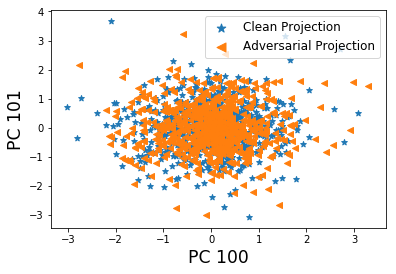

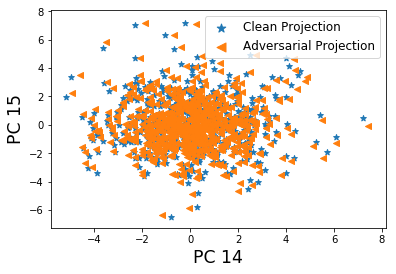

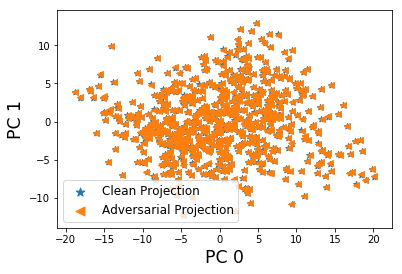

In [39]:
final = 100
high=14
low=0

plt.scatter( x=x_clean_t[:,final],
        y=x_clean_t[:,final+1],marker='*')

plt.scatter( x=x_adv_t[:,final],
        y=x_adv_t[:,final+1],marker='<')
plt.legend(['Clean Projection', 'Adversarial Projection'],markerscale=1.5, fontsize = 'large')
plt.xlabel('PC 100',fontsize = 'xx-large')
plt.ylabel('PC 101',fontsize = 'xx-large')
plt.figure()

plt.scatter( x=x_clean_t[:,high],
        y=x_clean_t[:,high+1],marker='*')

plt.scatter( x=x_adv_t[:,high],
        y=x_adv_t[:,high+1],marker='<')
plt.legend(['Clean Projection', 'Adversarial Projection'],markerscale=1.5, fontsize = 'large')
plt.xlabel('PC 14',fontsize = 'xx-large')
plt.ylabel('PC 15',fontsize = 'xx-large')
plt.figure()

plt.scatter( x=x_clean_t[:,low],
        y=x_clean_t[:,low+1],marker='*')
    #plt.figure()
plt.scatter( x=x_adv_t[:,low],
        y=x_adv_t[:,low+1],marker='<')
plt.legend(['Clean Projection', 'Adversarial Projection'],markerscale=1.5,fontsize = 'large')
plt.xlabel('PC 0',fontsize = 'xx-large')
plt.ylabel('PC 1',fontsize = 'xx-large')

In [40]:
state = {'x_adv_t': x_adv_t, 'x_clean_t': x_clean_t}
torch.save(state, './checkpoint_submission/PC_dim_SGD.h5')

## Cosine distance between adversarial and clean response PC components at Conv1 of ResNet18

Text(0,0.5,'Cosine Distance')

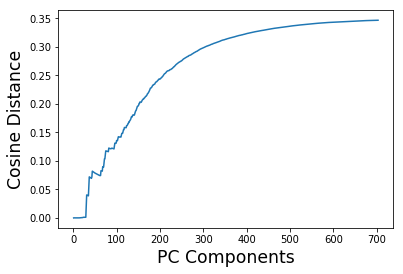

In [41]:
import scipy
dist_high=np.zeros(704)
for high in range(0,704):
    dist_high_x=0
    for i in range(0,704):
        dist_high_x += (scipy.spatial.distance.pdist(np.array((x_adv_t[i,0:high],
                                                          x_clean_t[i,0:high])), 'cosine'))
    dist_high[high]=np.mean(dist_high_x/704)
plt.plot(np.arange(0,704), dist_high)
plt.xlabel('PC Components',fontsize = 'xx-large')
plt.ylabel('Cosine Distance',fontsize = 'xx-large')